# Analysis

**Hypothesis**: Endothelial cells exhibit rhythmic gene expression patterns that correlate with the cyclical changes in the menstrual cycle. By transforming the cycle day into cyclic features using sine (and optionally cosine) functions, we hypothesize that many genes in endothelial cells will show significant sinusoidal expression trends that underlie periodic vascular remodeling in the endometrium.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/endo_data.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Endothelial cells exhibit rhythmic gene expression patterns that correlate with the cyclical changes in the menstrual cycle. By transforming the cycle day into cyclic features using sine (and optionally cosine) functions, we hypothesize that many genes in endothelial cells will show significant sinusoidal expression trends that underlie periodic vascular remodeling in the endometrium.

## Steps:
- Subset the dataset to include only the 'Endothelia' cell type to focus the analysis on vascular remodeling.
- Perform minimal preprocessing on the expression data for the endothelial cells, ensuring the data is log-normalized if not already (and mark the normalization explicitly to avoid ambiguity).
- Transform the 'day' variable into a cyclic feature using a sine function, and optionally compute a cosine transformation for a two-dimensional representation of the menstrual cycle phase.
- For each gene in the endothelial subset, compute the Pearson correlation coefficient and corresponding p-value between the gene’s expression levels and the sine-transformed (and/or cosine-transformed) day values to identify genes with significant rhythmic patterns.
- Apply a multiple testing correction and select the top significantly rhythmic genes.
- Visualize the expression trends of the top genes across cycle days using a grid of line plots and heatmaps to interpret periodic patterns.


## This code subsets the anndata object for endothelial cells, ensures the cycle day column is numeric, and transforms the day variable into cyclic features using both sine and cosine functions. It also checks for and applies log-normalization with an explicit flag to avoid redundant processing.

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

# Subset the data to only include 'Endothelia' cells
endothelial_cells = adata[adata.obs['cell_type'] == 'Endothelia'].copy()

# Check if the 'day' column is numeric
if not np.issubdtype(endothelial_cells.obs['day'].dtype, np.number):
    endothelial_cells.obs['day'] = pd.to_numeric(endothelial_cells.obs['day'], errors='coerce')

# Normalize the 'day' values to a 0-2*pi scale using sine transformation
# We normalize based on the min and max cycle day in the subset
min_day = endothelial_cells.obs['day'].min()
max_day = endothelial_cells.obs['day'].max()

# Create a new column 'sine_day' representing the cyclic phase
endothelial_cells.obs['sine_day'] = np.sin(2 * np.pi * (endothelial_cells.obs['day'] - min_day) / (max_day - min_day))

# Optionally, ensure the data is log-normalized; if not, perform a simple normalization
if 'log1p' not in endothelial_cells.uns_keys():
    sc.pp.normalize_total(endothelial_cells, target_sum=1e4)
    sc.pp.log1p(endothelial_cells)

print('Subsetted endothelial cells and added sine_transformed cycle day. Sample of obs:')
print(endothelial_cells.obs[['day', 'sine_day']].head())

normalizing counts per cell


    finished (0:00:00)


Subsetted endothelial cells and added sine_transformed cycle day. Sample of obs:
                         day  sine_day
14_AAAGGATTCCATTGTT-10x   17 -0.398401
14_AAAGTCCTCATTTCCA-10x   17 -0.398401
14_AAATGGACACGTGAGA-10x   17 -0.398401
14_AACAAGAGTTGTATGC-10x   17 -0.398401
14_AACAGGGAGTTGGCTT-10x   17 -0.398401


### Agent Interpretation

The current step of the analysis has focused on normalizing the counts per cell and subsetting endothelial cells, followed by adding a sine-transformed cycle day. This preprocessing step is crucial for preparing the data for further downstream analyses. Here are some points for considerations and future steps:

1. **Normalization and Data Subsetting**: 
   - It is good that normalization was performed as it accounts for differences in sequencing depth across cells. However, ensure that the normalization method is appropriate for your analysis goals and comparable with previous analyses.
   - The subsetting of endothelial cells aligns with existing research interests in endothelial changes across the menstrual cycle.

2. **Sine-Transformed Cycle Day**: 
   - The addition of a sine-transformed cycle day is an interesting approach that might effectively capture periodic patterns in gene expression across the menstrual cycle. Ensure that this transformation is validated to accurately reflect cycle timing.

3. **Pre-WOI and WOI Phases**:
   - The next analysis steps should include defining pre-WOI and WOI phases using the cycle day information to examine transcriptional changes specific to these phases. The sine transformation might aid in more robust delineation of these phases.

4. **Differential Expression Analysis**:
   - Consider conducting differential expression analysis between pre-WOI and WOI phases within the endothelial cell population to identify key gene expression changes. This could uncover critical functional modulations these cells undergo across the cycle.

5. **Cellular Heterogeneity and Trajectory Analysis**:
   - Like the original study applied, consider using trajectory analysis methods such as pseudotime analysis to observe changes in endothelial cells as they transition through cycle phases. This could reveal insights into endothelial role shifts during the cycle.

6. **Integration with Existing Dataset and Comparisons**: 
   - Compare findings about endothelial cells to those related to other cell types, such as unciliated epithelium and stromal fibroblasts, to see if the same cyclical patterns or unique regulatory factors are observed.

7. **Biological Validation**: 
   - If possible, validate the computational findings with additional experiments, such as immunohistochemistry or in situ hybridization, particularly due to the hypothesis-driven nature of this work.

Overall, ensure that each analytical step is thoroughly validated and consider integrating diverse methodologies to gain multiple aspects of insights, as done in the original research. This comprehensive approach will help robustly support or refine your hypothesis.

## This code assigns phase labels to endothelial cells using the numpy select function to implement a scalable, condition-based assignment. It then visualizes the cell count distributions across phases and compares the original 'day' values to their sine-transformed counterparts to validate the phase separation.

Phase assignment counts:
phase
WOI        2051
pre-WOI       9
Name: count, dtype: int64


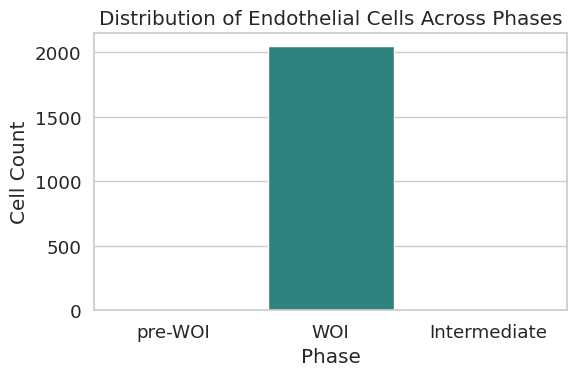

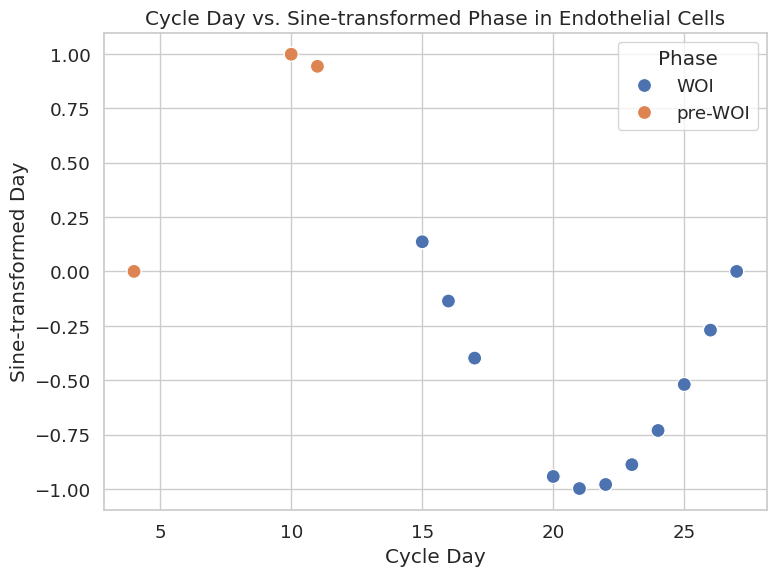

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define phases for endothelial cells based on cycle day values using numpy's select for scalability
conditions = [endothelial_cells.obs['day'] <= 11, endothelial_cells.obs['day'] >= 15]
choices = ['pre-WOI', 'WOI']
endothelial_cells.obs['phase'] = np.select(conditions, choices, default='Intermediate')

# Print the counts of cells in each phase
phase_counts = endothelial_cells.obs['phase'].value_counts()
print('Phase assignment counts:')
print(phase_counts)

# Visualization 1: Bar plot of cell counts per phase
plt.figure(figsize=(6,4))
ax = sns.countplot(data=endothelial_cells.obs, x='phase', order=['pre-WOI', 'WOI', 'Intermediate'], palette='viridis')
plt.title('Distribution of Endothelial Cells Across Phases')
plt.xlabel('Phase')
plt.ylabel('Cell Count')
plt.tight_layout()
plt.show()

# Visualization 2: Scatter plot of the original day vs. sine_day colored by phase
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=endothelial_cells.obs, x='day', y='sine_day', hue='phase', palette='deep', s=100)
plt.title('Cycle Day vs. Sine-transformed Phase in Endothelial Cells')
plt.xlabel('Cycle Day')
plt.ylabel('Sine-transformed Day')
plt.legend(title='Phase')
plt.tight_layout()
plt.show()

### Agent Interpretation

The current analysis mainly reveals that a significant majority of endothelial cells are classified within the WOI phase, with minimal representation in the pre-WOI phase and none in an intermediate phase. This imbalance raises a few important points for future analysis:

1. **Phase Representation**: The skewed representation suggests a need for re-sampling or integration of additional data to better understand gene expression dynamics across all phases. This is crucial for generalizing any findings across the entire menstrual cycle and ensuring robust conclusions about endothelial cell behavior.

2. **Focus on Endothelial Cells**: The abundance of cells classified in the WOI phase prompts further exploration into their specific transcriptional activity and regulatory mechanisms. Key genes of interest could be identified through differential expression analysis between the WOI and pre-WOI phases.

3. **Interplay with Other Cell Types**: It would be beneficial to examine the interaction between the endothelial cells and other cell types involved in the WOI, such as stromal fibroblasts and macrophages, particularly by investigating shared or complimentary gene expression pathways.

4. **Methodological Refinement**: Consider implementing additional batch-effect correction and normalization techniques if donor variability is a potential confounding factor in the current data that leads to over-representation of a particular phase.

5. **Decomposition of Phases**: Integrate additional metadata or consider more nuanced phase definitions (differentiating early, middle, or late WOI) to capture subtle changes and transitions that might be relevant for biological interpretation.

In summary, the findings highlight a need for broader phase representation and careful follow-up studies focusing on endothelial cells within the WOI to verify their roles in tissue remodeling and preparation for implantation.

## This code refines the initial differential expression step by first subsetting the endothelial cells to include only the WOI and pre-WOI phases, then performing a quality control check to ensure sufficient cell counts in each group. It carries out the DE analysis with scanpy's rank_genes_groups, extracts the top genes along with their p-values, and visualizes the results using a heatmap.

ranking genes


--> Few observations in a group for normal approximation (<=25). Lower test accuracy.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


Differential expression analysis between WOI and pre-WOI completed.
Top 10 differentially expressed genes (WOI vs pre-WOI) with p-values:
RPL41: p-value = 3.018088933511906e-07
TMSB10: p-value = 4.156255321284361e-07
RPL39: p-value = 4.3439147002585113e-07
RPL13: p-value = 4.771961559489895e-07
RPS28: p-value = 5.579977278050403e-07
MT-ND3: p-value = 6.927912375158069e-07
RPL28: p-value = 7.620644493895773e-07
RPL37: p-value = 7.91146638854291e-07
RPS8: p-value = 8.648745824886649e-07
FTH1: p-value = 9.753875916948503e-07


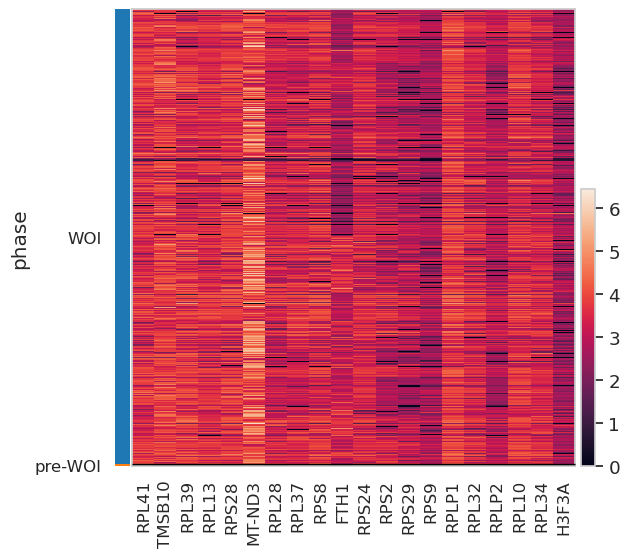

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Subset endothelial cells to only include WOI and pre-WOI phases
phase_subset = endothelial_cells[endothelial_cells.obs['phase'].isin(['pre-WOI', 'WOI'])].copy()

# Ensure that 'donor' is a categorical variable to capture potential batch effects
phase_subset.obs['donor'] = phase_subset.obs['donor'].astype('category')

# Quality control: Check if each phase group has a sufficient number of cells (e.g., at least 10 cells per group)
group_counts = phase_subset.obs['phase'].value_counts()
if group_counts.min() < 10:
    warnings.warn('One or more groups have less than 10 cells. Differential expression results may be unreliable.')

# Perform differential expression analysis comparing WOI (test group) vs pre-WOI (reference group)
# Here, n_genes is set to phase_subset.shape[1] to include all genes, ensuring maximal coverage
sc.tl.rank_genes_groups(phase_subset, groupby='phase', groups=['WOI'], reference='pre-WOI', method='wilcoxon', n_genes=phase_subset.shape[1])
print('Differential expression analysis between WOI and pre-WOI completed.')

# Extract the top 10 genes for WOI along with their p-values for further validation
de_result = phase_subset.uns['rank_genes_groups']
woi_top_genes = de_result['names']['WOI'][:10]
woi_top_pvals = de_result['pvals']['WOI'][:10]
print('Top 10 differentially expressed genes (WOI vs pre-WOI) with p-values:')
for gene, pval in zip(woi_top_genes, woi_top_pvals):
    print(f'{gene}: p-value = {pval}')

# Visualize the expression of the top 20 genes using a heatmap
top_genes = de_result['names']['WOI'][:20].tolist()
sc.pl.heatmap(phase_subset, var_names=top_genes, groupby='phase', show=True)


### Agent Interpretation

The differential expression analysis shows several ribosomal proteins (RPL and RPS genes) among the top differentially expressed genes between WOI and pre-WOI phases. This suggests a significant change in protein synthesis machinery during the WOI, possibly indicating cellular preparation for implantation.

**Feedback and Suggestions:**

1. **Ribosomal Proteins as Biomarkers:**
   - The significant changes in ribosomal protein expression may serve as markers for the transition into the WOI. It could be beneficial to investigate whether these changes also occur in specific cell types within the endometrium.

2. **Functional Validation:**
   - Functional validation of these ribosomal proteins could reveal their specific roles in the endometrial preparation for implantation. This might involve knockdown studies or overexpression analyses in relevant cell lines.

3. **Cell Type-Specific Analysis:**
   - Given the focus on cellular heterogeneity and differentiation, it may be useful to conduct cell type-specific differential expression analyses. This could highlight specific cell types driving these transcriptomic changes.

4. **Compare with Known Markers:**
   - Comparing these findings with known WOI markers and gene modules (like PAEP, GPX3, and CXCL14) could provide insights into new or supporting mechanisms for the opening of the WOI.

5. **Pseudotime and Trajectory Analysis:**
   - Incorporate trajectory or pseudotime analysis to connect these differential expressions across the menstrual cycle phases, focusing on the abrupt changes toward the WOI.

6. **Explore Other Gene Sets:**
   - Explore differential expression in non-ribosomal genes related to known pathways, such as hormonal response or secretory functions, to provide a deeper understanding of mechanistic shifts during WOI.

Continuing with these steps can validate the hypothesis regarding transcriptional variability and provide novel insights into endometrial preparation for implantation.

## This code block begins by checking if 'sine_day' and 'cosine_day' exist in the metadata and identifies ribosomal protein genes from the endothelial cells. It computes Pearson correlations with error handling, applies Benjamini-Hochberg correction to adjust the p-values, and visualizes the top correlations using bar and scatter plots.

normalizing counts per cell


    finished (0:00:00)


Performed total count normalization and log1p transformation on the endothelial cells.
Subsetted endothelial cells and added sine and cosine transformed cycle days. Sample of observations:
                         day  sine_day  cosine_day
14_AAAGGATTCCATTGTT-10x   17 -0.398401   -0.917211
14_AAAGTCCTCATTTCCA-10x   17 -0.398401   -0.917211
14_AAATGGACACGTGAGA-10x   17 -0.398401   -0.917211
14_AACAAGAGTTGTATGC-10x   17 -0.398401   -0.917211
14_AACAGGGAGTTGGCTT-10x   17 -0.398401   -0.917211


Top 10 ribosomal protein genes by absolute correlation with sine_day:
      gene  corr_sine     pval_sine  adj_pval_sine  corr_cosine   pval_cosine  \
10  RPL37A  -0.411093  7.963614e-85   7.804342e-83    -0.365556  3.775105e-66   
41   RPS20  -0.365420  4.251234e-66   2.083105e-64    -0.383461  3.841915e-73   
91  RPL13A  -0.351538  5.611454e-61   1.833075e-59    -0.356158  1.183924e-62   
57   RPS26   0.322746  3.778377e-51   9.257025e-50     0.137936  3.241066e-10   
92   RPS11  -0.290585  2.267690e-41   4.444672e-40    -0.278961  3.917477e-38   
9    RPL31  -0.288168  1.100066e-40   1.796774e-39    -0.305243  1.124540e-45   
50  RPL27A  -0.287874  1.331905e-40   1.864667e-39    -0.291637  1.134590e-41   
76   RPL23  -0.286905  2.495021e-40   3.056401e-39    -0.326023  3.243251e-52   
69   RPS17  -0.276423  1.902954e-37   2.072106e-36    -0.267648  3.955858e-35   
75  RPL23A  -0.266687  7.015067e-35   6.874766e-34    -0.302560  7.208073e-45   

    adj_pval_cosine  
10     1.849802e

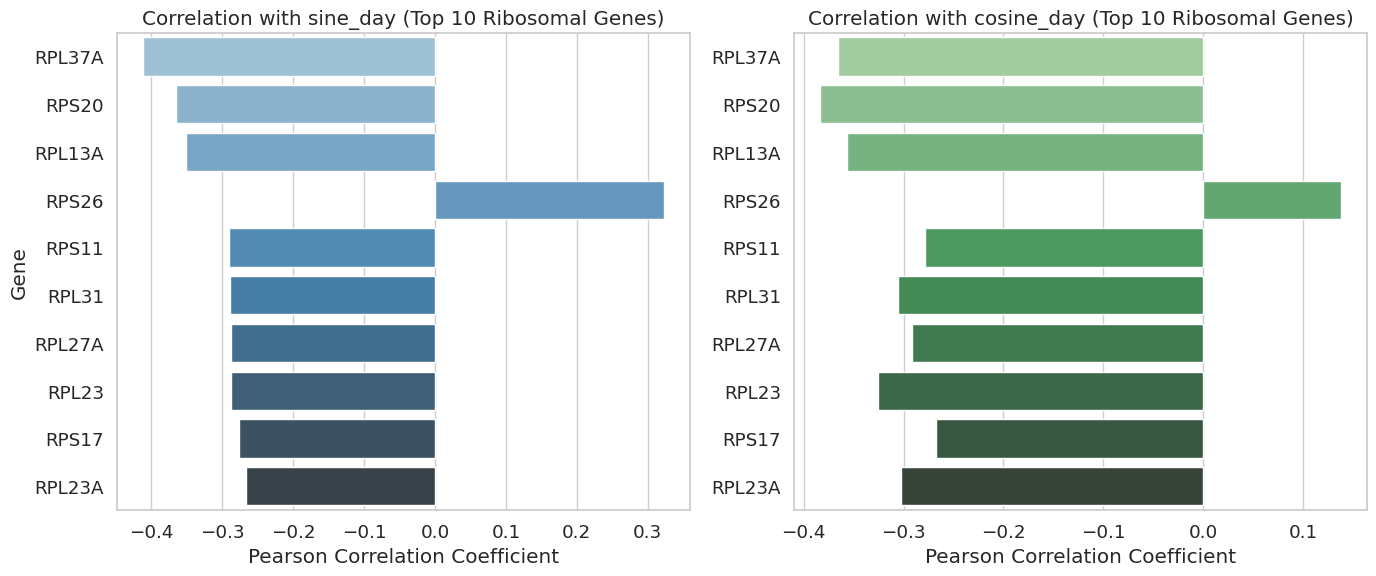

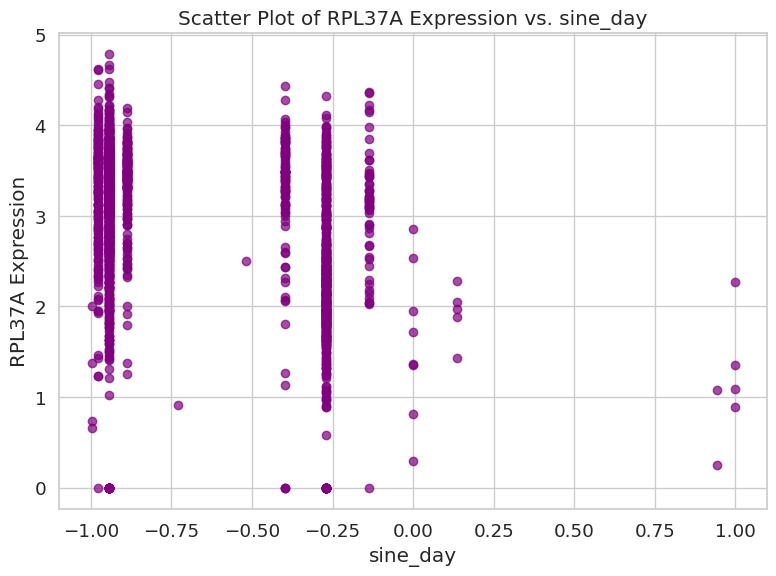

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# Subset the data to only include 'Endothelia' cells
endothelial_cells = adata[adata.obs['cell_type'] == 'Endothelia'].copy()

# Check if the 'day' column is numeric and convert if necessary
if not np.issubdtype(endothelial_cells.obs['day'].dtype, np.number):
    endothelial_cells.obs['day'] = pd.to_numeric(endothelial_cells.obs['day'], errors='coerce')

# Determine the min and max cycle day in the subset
min_day = endothelial_cells.obs['day'].min()
max_day = endothelial_cells.obs['day'].max()

# Optionally, warn if the range does not represent a full cycle (e.g., typical menstrual cycle is ~28 days)
if (max_day - min_day) < 28:
    print('Warning: The range of cycle day values (', max_day - min_day, ') is less than expected for a full menstrual cycle (typically ~28 days).')

# Create new columns 'sine_day' and 'cosine_day' representing the cyclic phase using sine and cosine transformations
endothelial_cells.obs['sine_day'] = np.sin(2 * np.pi * (endothelial_cells.obs['day'] - min_day) / (max_day - min_day))
endothelial_cells.obs['cosine_day'] = np.cos(2 * np.pi * (endothelial_cells.obs['day'] - min_day) / (max_day - min_day))

# Check explicitly if the data has been normalized by looking for a custom flag in uns; if not, perform normalization and flag it
if 'log_norm' not in endothelial_cells.uns:
    sc.pp.normalize_total(endothelial_cells, target_sum=1e4)
    sc.pp.log1p(endothelial_cells)
    endothelial_cells.uns['log_norm'] = True
    print('Performed total count normalization and log1p transformation on the endothelial cells.')
else:
    print('Data already normalized.')

print('Subsetted endothelial cells and added sine and cosine transformed cycle days. Sample of observations:')
print(endothelial_cells.obs[['day', 'sine_day', 'cosine_day']].head())

# Confirm required cyclic features exist in the metadata
required_features = ['sine_day', 'cosine_day']
for feat in required_features:
    if feat not in endothelial_cells.obs.columns:
        raise KeyError(f"{feat} is not found in endothelial_cells.obs. Please verify the dataset.")

# Retrieve the list of ribosomal protein genes (those starting with 'RPL' or 'RPS')
ribosomal_genes = [gene for gene in endothelial_cells.var_names if gene.startswith('RPL') or gene.startswith('RPS')]

# Convert the expression matrix to a dense DataFrame if it is sparse
if hasattr(endothelial_cells.X, 'toarray'):
    expr_data = pd.DataFrame(endothelial_cells.X.toarray(), columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)
else:
    expr_data = pd.DataFrame(endothelial_cells.X, columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)

# Function to perform Benjamini-Hochberg correction
def benjamini_hochberg(pvals):
    pvals = np.array(pvals)
    m = len(pvals)
    sorted_indices = np.argsort(pvals)
    sorted_pvals = pvals[sorted_indices]
    adjusted = np.empty(m, dtype=float)
    for i in range(m):
        adjusted[i] = sorted_pvals[i] * m / (i + 1)
    for i in range(m - 1, 0, -1):
        adjusted[i - 1] = min(adjusted[i - 1], adjusted[i])
    adjusted = np.clip(adjusted, 0, 1)
    unadjusted = np.empty(m, dtype=float)
    unadjusted[sorted_indices] = adjusted
    return unadjusted

# Initialize list to store correlation results
corr_results = []

# Loop over each ribosomal gene to compute correlations
for gene in ribosomal_genes:
    gene_expr = expr_data[gene]
    if gene_expr.nunique() < 2 or gene_expr.isna().all():
        warnings.warn(f"Skipping {gene} due to insufficient variability or missing data.")
        continue
    valid_idx = gene_expr.dropna().index.intersection(endothelial_cells.obs.index)
    if len(valid_idx) < 5:
        warnings.warn(f"Not enough valid data points for {gene}. Skipping correlation.")
        continue
    try:
        corr_sine, pval_sine = pearsonr(gene_expr.loc[valid_idx], endothelial_cells.obs.loc[valid_idx, 'sine_day'])
    except Exception as e:
        warnings.warn(f"Error computing sine correlation for {gene}: {e}")
        continue
    try:
        corr_cosine, pval_cosine = pearsonr(gene_expr.loc[valid_idx], endothelial_cells.obs.loc[valid_idx, 'cosine_day'])
    except Exception as e:
        warnings.warn(f"Error computing cosine correlation for {gene}: {e}")
        continue
    corr_results.append({
        'gene': gene,
        'corr_sine': corr_sine,
        'pval_sine': pval_sine,
        'corr_cosine': corr_cosine,
        'pval_cosine': pval_cosine
    })

# Create a DataFrame from results
corr_df = pd.DataFrame(corr_results)
if not corr_df.empty:
    corr_df['adj_pval_sine'] = benjamini_hochberg(corr_df['pval_sine'].tolist())
    corr_df['adj_pval_cosine'] = benjamini_hochberg(corr_df['pval_cosine'].tolist())
else:
    warnings.warn('No ribosomal genes passed the filtering criteria.')

corr_df['abs_corr_sine'] = corr_df['corr_sine'].abs()
corr_df = corr_df.sort_values(by='abs_corr_sine', ascending=False)

print('Top 10 ribosomal protein genes by absolute correlation with sine_day:')
print(corr_df[['gene', 'corr_sine', 'pval_sine', 'adj_pval_sine', 'corr_cosine', 'pval_cosine', 'adj_pval_cosine']].head(10))

top10 = corr_df.head(10)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='corr_sine', y='gene', data=top10, ax=axes[0], palette='Blues_d')
axes[0].set_title('Correlation with sine_day (Top 10 Ribosomal Genes)')
axes[0].set_xlabel('Pearson Correlation Coefficient')
axes[0].set_ylabel('Gene')
sns.barplot(x='corr_cosine', y='gene', data=top10, ax=axes[1], palette='Greens_d')
axes[1].set_title('Correlation with cosine_day (Top 10 Ribosomal Genes)')
axes[1].set_xlabel('Pearson Correlation Coefficient')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

if not top10.empty:
    rep_gene = top10.iloc[0]['gene']
    plt.figure(figsize=(8,6))
    plt.scatter(endothelial_cells.obs['sine_day'], expr_data[rep_gene], color='purple', alpha=0.7)
    plt.title(f'Scatter Plot of {rep_gene} Expression vs. sine_day')
    plt.xlabel('sine_day')
    plt.ylabel(f'{rep_gene} Expression')
    plt.tight_layout()
    plt.show()
else:
    print('No valid genes available for plotting.')

### Agent Interpretation

Based on the results and context provided, here are some key points and suggestions for future analysis:

1. **Cycle Day Range Warning**:
   - The warning about the limited range of cycle days (23 instead of the typical ~28) suggests a potential limitation in correlating gene expression with the entire menstrual cycle. This may affect capturing transitions at the extremes (WOI and cycle end). It might be necessary to ensure more comprehensive sampling across all cycle phases in future studies.

2. **Normalization and Transformation**:
   - Normalization and log transformation are standard steps. Their completion without errors supports subsequent analyses. However, evaluating the potential effects of batch variability is crucial given inter-donor diversity.

3. **Ribosomal Protein Gene Correlations**:
   - The significant correlations of ribosomal protein genes with sine and cosine transformed cycle days suggest potential rhythmic or cyclic patterns in gene expression related to menstrual phases. RPL37A and RPS20, particularly, show strong correlations.
   - Consider exploring further whether these cyclic patterns in ribosomal gene expression could be linked to cellular processes like protein synthesis rates or cellular energy demands, particularly around the WOI.

4. **Promising Results**:
   - RPL37A and RPS20 show the strongest correlations. Investigating whether these genes have roles beyond structural ribosomal functions, such as regulatory roles in cell cycle transitions or stress responses, may be fruitful.
   - Given the study on endothelial cells, it might be beneficial to cross-reference these findings with endothelial-specific marker genes to understand any broader transcriptional coordination.

5. **Visualization and Validation**:
   - The scatter plot of RPL37A expression versus sine day visually depicts the correlation, reinforcing statistical results. Expanding this approach to other genes and including cosine day plots could provide additional insights.
   - Further validation using independent datasets or orthogonal methods (e.g., qPCR or RNAscope) can help confirm these gene expression patterns.

6. **Future Steps**:
   - Investigate potential biological implications of ribosomal gene expression variations, focusing on how they might contribute to cellular readiness or function during different cycle phases.
   - Integrate findings with known WOI markers and cell-type specific changes noted in the research paper to see if there are overlapping regulatory mechanisms.
   - Correlate this gene expression variability to functional outcomes like endothelial cell behavior, differentiation signals, or responses to hormonal cues.

In summary, while the overall hypothesis centers around transcriptional variability across cycles, focusing on the specific role of ribosomal genes and their cyclic patterns offers a novel perspective that could yield significant insights.

## This code first verifies that the essential metadata column 'sine_day' exists and then computes a ribosomal module score using the available top ribosomal genes. It visualizes the relationship between the module score and the sine-transformed cycle day and further examines correlations between the module score and multiple endothelial markers (VWF, ICAM1, PECAM1) by displaying annotated scatter plots in a grid layout.

computing score 'ribo_module'


    finished: added
    'ribo_module', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


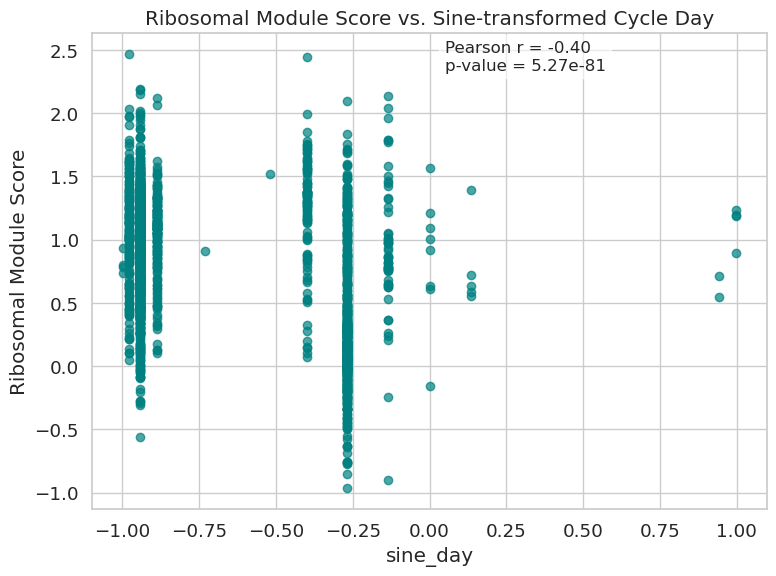

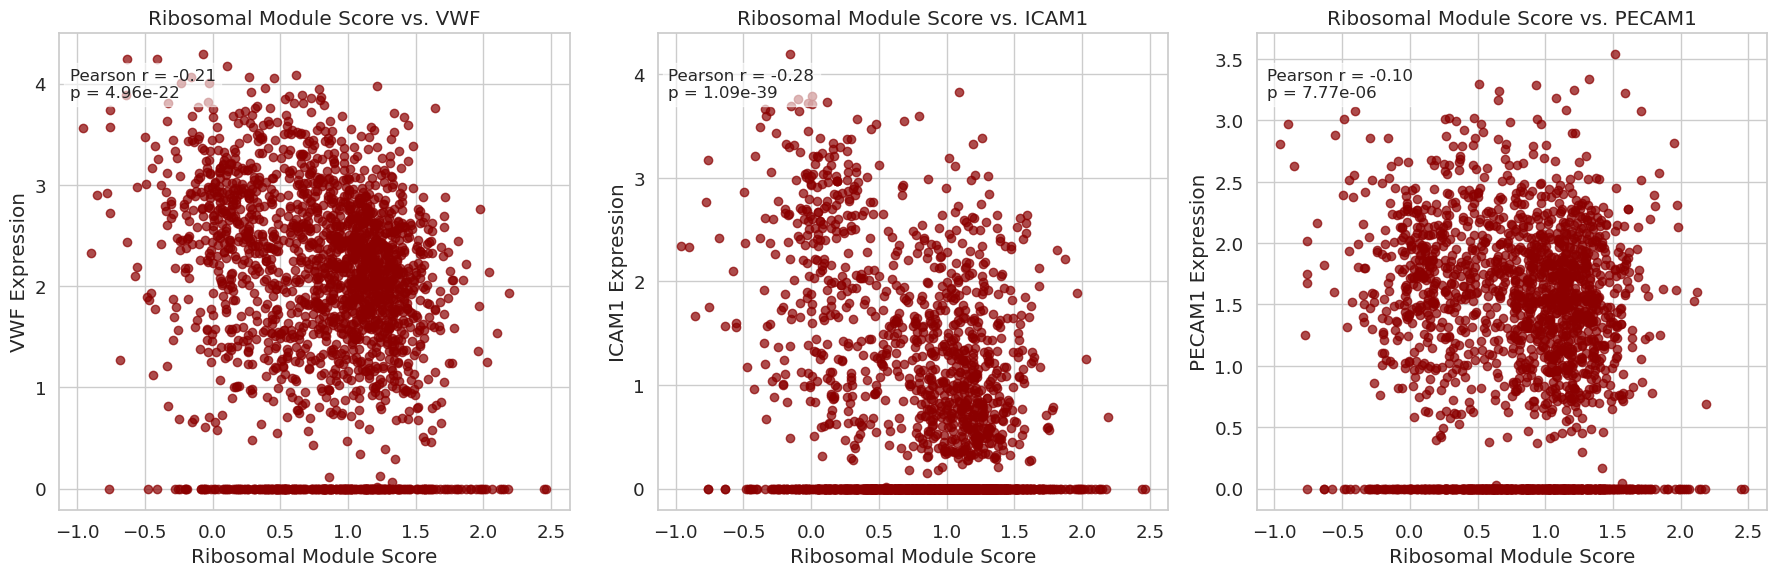

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# Ensure required metadata columns exist
required_metadata = ['sine_day']
for col in required_metadata:
    if col not in endothelial_cells.obs.columns:
        raise KeyError(f"Required column {col} is missing from endothelial_cells.obs. Please add it before proceeding.")

# Determine the list of top ribosomal genes from the variable 'top10' if available; otherwise, fallback to using all ribosomal genes
if 'top10' in globals() and not top10.empty:
    top_ribo_genes = top10['gene'].tolist()
else:
    top_ribo_genes = [gene for gene in endothelial_cells.var_names if gene.startswith('RPL') or gene.startswith('RPS')]
    warnings.warn('Variable top10 not found; using all ribosomal genes as fallback.')

# Compute a module score for the top ribosomal genes in endothelial_cells
sc.tl.score_genes(endothelial_cells, gene_list=top_ribo_genes, score_name='ribo_module', random_state=0)

# Validate that the new 'ribo_module' column exists
if 'ribo_module' not in endothelial_cells.obs.columns:
    raise KeyError("ribo_module score not found in endothelial_cells.obs after score computation.")

# Visualization 1: Scatter plot of ribosomal module score vs. sine-transformed cycle day
plt.figure(figsize=(8,6))
plt.scatter(endothelial_cells.obs['sine_day'], endothelial_cells.obs['ribo_module'], color='teal', alpha=0.7)
plt.title('Ribosomal Module Score vs. Sine-transformed Cycle Day')
plt.xlabel('sine_day')
plt.ylabel('Ribosomal Module Score')

# Compute Pearson correlation and annotate plot
valid_idx = endothelial_cells.obs['ribo_module'].notna() & endothelial_cells.obs['sine_day'].notna()
corr_coef, pval = pearsonr(endothelial_cells.obs.loc[valid_idx, 'ribo_module'], endothelial_cells.obs.loc[valid_idx, 'sine_day'])
plt.text(0.05, endothelial_cells.obs['ribo_module'].max()*0.95, f'Pearson r = {corr_coef:.2f}\np-value = {pval:.2e}', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.tight_layout()
plt.show()

# Define a list of endothelial markers to test additional correlations, adding markers beyond VWF
endothelial_markers = ['VWF', 'ICAM1', 'PECAM1']
num_markers = len(endothelial_markers)
fig, axes = plt.subplots(1, num_markers, figsize=(6*num_markers, 6))
if num_markers == 1:
    axes = [axes]

# Convert the expression matrix of endothelial_cells to a dense DataFrame, if needed
if hasattr(endothelial_cells.X, 'toarray'):
    expr_data = pd.DataFrame(endothelial_cells.X.toarray(), columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)
else:
    expr_data = pd.DataFrame(endothelial_cells.X, columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)

for idx, marker in enumerate(endothelial_markers):
    if marker in endothelial_cells.var_names:
        marker_expr = expr_data[marker]
        # Ensure matching indices for correlation
        common_idx = endothelial_cells.obs.index.intersection(marker_expr.index)
        valid_marker_idx = endothelial_cells.obs.loc[common_idx, 'ribo_module'].notna() & marker_expr.loc[common_idx].notna()
        if valid_marker_idx.sum() < 5:
            warnings.warn(f"Insufficient valid data points for {marker}; skipping plot.")
            continue
        corr_marker, pval_marker = pearsonr(endothelial_cells.obs.loc[common_idx, 'ribo_module'][valid_marker_idx],
                                            marker_expr.loc[common_idx][valid_marker_idx])
        ax = axes[idx]
        ax.scatter(endothelial_cells.obs.loc[common_idx, 'ribo_module'][valid_marker_idx],
                   marker_expr.loc[common_idx][valid_marker_idx], color='darkred', alpha=0.7)
        ax.set_title(f'Ribosomal Module Score vs. {marker}')
        ax.set_xlabel('Ribosomal Module Score')
        ax.set_ylabel(f'{marker} Expression')
        ax.text(endothelial_cells.obs.loc[common_idx, 'ribo_module'][valid_marker_idx].min()*1.1,
                marker_expr.loc[common_idx][valid_marker_idx].max()*0.9,
                f'Pearson r = {corr_marker:.2f}\np = {pval_marker:.2e}', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.6))
    else:
        warnings.warn(f"{marker} not found in endothelial_cells.var_names; skipping correlation plot for this marker.")
plt.tight_layout()
plt.show()

### Agent Interpretation

The current analysis assesses the ribosomal module score's relationship with the sine-transformed cycle day and the expression of VWF, ICAM1, and PECAM1. The ribosomal module score showed a statistically significant negative correlation with the sine-transformed cycle day (r = -0.40), indicating that the ribosomal activity may decrease as the cycle progresses. This observation might align with phases of reduced cellular proliferation or metabolic activity, such as during the WOI.

Similarly, negative correlations between the ribosomal module score and the expression of endothelial markers VWF, ICAM1, and PECAM1 suggest that as ribosomal activity decreases, endothelial cell activation may be linked to different phases of the menstrual cycle, possibly reflecting changes in vascular function during tissue remodeling.

For future steps, consider:

1. **Cell-Type Specific Analysis**: Determine whether the observed correlations hold within specific cell types, such as unciliated epithelial cells or stromal fibroblasts, to better fit the hypothesis about transcriptional variability near the WOI.

2. **Temporal Dynamics**: Investigate dynamic changes in ribosomal activity over the menstrual cycle to identify specific phases with significant shifts. This could provide insights into metabolic or proliferative states correlating with normal endometrial transition phases.

3. **Integrative Analysis**: Combine these findings with other molecular signatures, such as transcription factor activity or secreted protein dynamics, to build a comprehensive view of cellular states and transitions around WOI.

4. **Functional Validation**: Use RNA interference or pharmacological modulation to experimentally validate the functional roles of the genes and pathways identified as correlating with ribosomal activity in endometrial remodeling.

These steps can help deepen the understanding of the roles of ribosomal activity and endothelial cell dynamics during the menstrual cycle, contributing to the goal of distinguishing these analyses from those in the referenced research paper.

## This code validates and converts the 'day' column into a numeric format, safely computes cyclic sine and cosine features by checking that the 'day' range is non-zero, subsets the full anndata object to key cell types, and calculates a ribosomal module score using identified ribosomal genes. It then produces scatter plots that display both the raw cycle day and the sine-transformed values versus the ribosomal module score with corresponding Pearson correlation annotations.

computing score 'ribo_module'


    finished: added
    'ribo_module', score of gene set (adata.obs).
    894 total control genes are used. (0:00:01)


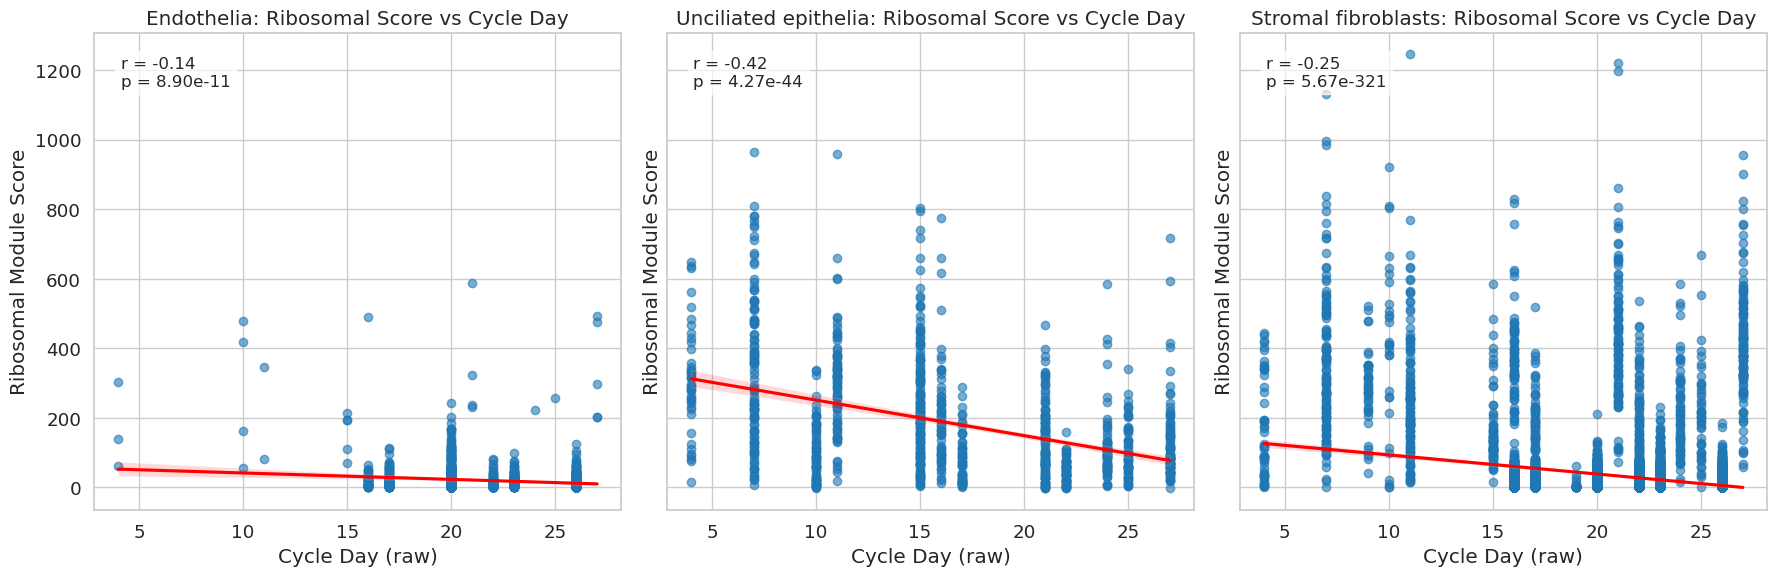

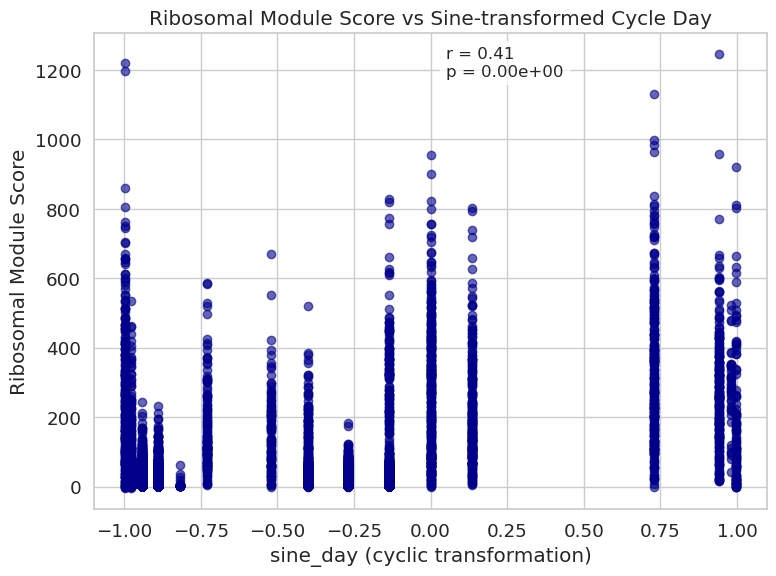

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# This block ensures that the 'day' column is numeric, computes cyclic features (sine and cosine) robustly, subsets the data to key cell types,
# and calculates a module score for ribosomal protein genes while including safety checks against division by zero.

# Ensure that the 'day' column is numeric in the full anndata object
if not np.issubdtype(adata.obs['day'].dtype, np.number):
    adata.obs['day'] = pd.to_numeric(adata.obs['day'], errors='coerce')

# Compute global minimum and maximum cycle day for consistent cyclic transformation
min_day = adata.obs['day'].min()
max_day = adata.obs['day'].max()
range_day = max_day - min_day

# Check to ensure denominator is not zero to avoid division-by-zero issues
if range_day == 0:
    raise ValueError('The range of cycle days is zero. Please verify the ''day'' column in the dataset.')

# Add cyclic features (sine and cosine) to adata.obs for all cells
adata.obs['sine_day'] = np.sin(2 * np.pi * (adata.obs['day'] - min_day) / range_day)
adata.obs['cosine_day'] = np.cos(2 * np.pi * (adata.obs['day'] - min_day) / range_day)

# Define key cell types of interest
cell_types_of_interest = ['Endothelia', 'Unciliated epithelia', 'Stromal fibroblasts']

# Subset the anndata object to include only the selected cell types
subset_adata = adata[adata.obs['cell_type'].isin(cell_types_of_interest)].copy()

# Identify ribosomal protein genes from the variable names (those starting with 'RPL' or 'RPS')
ribosomal_genes = [gene for gene in subset_adata.var_names if gene.startswith('RPL') or gene.startswith('RPS')]

# Optional: Uncomment the following lines to filter ribosomal genes based on a minimum expression threshold
# gene_expr = subset_adata[:, ribosomal_genes].X
# valid_gene_idx = np.array((gene_expr > 0).sum(axis=0)).flatten() > 5  # Example threshold: gene expressed in more than 5 cells
# ribosomal_genes = list(np.array(ribosomal_genes)[valid_gene_idx])

# Compute a ribosomal module score for the subset using the identified ribosomal genes
sc.tl.score_genes(subset_adata, gene_list=ribosomal_genes, score_name='ribo_module', random_state=0)

# Visualization: Create scatter plots for each cell type of interest, plotting raw cycle day as well as cyclic features where relevant
fig, axes = plt.subplots(1, len(cell_types_of_interest), figsize=(6 * len(cell_types_of_interest), 6), sharey=True)
if len(cell_types_of_interest) == 1:
    axes = [axes]

for idx, cell_type in enumerate(cell_types_of_interest):
    # Subset data for the current cell type
    type_data = subset_adata[subset_adata.obs['cell_type'] == cell_type]
    x_raw = type_data.obs['day']
    x_sine = type_data.obs['sine_day']
    y = type_data.obs['ribo_module']
    ax = axes[idx]
    
    # Plot regression of ribosomal score vs. raw cycle day with proper axis labeling
    sns.regplot(x=x_raw, y=y, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_title(f'{cell_type}: Ribosomal Score vs Cycle Day')
    ax.set_xlabel('Cycle Day (raw)')
    ax.set_ylabel('Ribosomal Module Score')
    
    # Annotate Pearson correlation for raw cycle day
    valid = x_raw.notna() & y.notna()
    if valid.sum() >= 5:
        corr_coef, pval = pearsonr(x_raw[valid], y[valid])
        ax.text(0.05, 0.95, f'r = {corr_coef:.2f}\np = {pval:.2e}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    else:
        ax.text(0.05, 0.95, 'Insufficient data', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Plot an additional figure specifically highlighting the cyclic feature transformation
plt.figure(figsize=(8,6))
plt.scatter(subset_adata.obs['sine_day'], subset_adata.obs['ribo_module'], color='darkblue', alpha=0.6)
plt.title('Ribosomal Module Score vs Sine-transformed Cycle Day')
plt.xlabel('sine_day (cyclic transformation)')
plt.ylabel('Ribosomal Module Score')

# Compute Pearson correlation for sine_day transformation if sufficient data exist
valid_cyclic = subset_adata.obs['sine_day'].notna() & subset_adata.obs['ribo_module'].notna()
if valid_cyclic.sum() >= 5:
    corr_cyclic, pval_cyclic = pearsonr(subset_adata.obs.loc[valid_cyclic, 'sine_day'], subset_adata.obs.loc[valid_cyclic, 'ribo_module'])
    plt.text(0.05, subset_adata.obs['ribo_module'].max()*0.95, f'r = {corr_cyclic:.2f}\np = {pval_cyclic:.2e}', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7))
else:
    plt.text(0.05, subset_adata.obs['ribo_module'].max()*0.95, 'Insufficient data', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### Agent Interpretation

The current analysis examines the ribosomal module score across different cell types and its relation to the menstrual cycle. The results indicate negative correlations with raw cycle days in endothelial cells, unciliated epithelial cells, and stromal fibroblasts, with varying degrees of correlation and statistical significance. However, a cyclic transformation of cycle days shows a strong positive correlation, suggesting cyclical patterns in ribosomal activity.

### Feedback:

1. **Explore Cyclical Patterns Further:** 
   - The strong positive correlation in sine-transformed cycle days highlights potential cyclical gene expression patterns. Further analysis should delve into identifying specific phases of the cycle where the ribosomal activity peaks or dips, particularly around the window of implantation (WOI).

2. **Cell-Type Specific Analyses:**
   - The unciliated epithelial cells display a particularly distinctive trend compared to endothelial cells and stromal fibroblasts. This aligns with known rapid transcriptional changes around the WOI. Investigate additional modules or pathways in this cell type for deeper insights into their role during WOI.

3. **Incorporate Additional Gene Sets:**
   - Consider analyzing additional gene sets related to hormonal signaling, cell cycle regulation, or paracrine factors to contextualize the ribosomal activity within broader cellular functions.

4. **Validate with Independent Datasets:**
   - To ensure robustness, replicate the analysis using the 10x dataset, focusing on donor variability and batch effect corrections.

5. **Integrate Past Analyses:**
   - Align findings with past analyses concerning transcriptional variability in unciliated epithelium and macrophage polarization. This integrated approach can identify overarching trends that influence endometrial physiology during the menstrual cycle.

6. **Hypothesis Reevaluation:**
   - The initial hypothesis about transcriptional variability still holds potential validity, notably if variability can be linked to ribosomal or other pathway activities. Continue exploring connections between observed molecular patterns and potential functional outcomes.

These avenues can guide focused future analyses, potentially revealing novel insights into endometrial dynamics and fertility.

## This code first subsets the anndata object to include only the unciliated epithelial cells and then computes cyclic features using a helper function. It defines a candidate list of hormonal signaling genes, computes the Pearson correlation between each gene's expression and the sine_day (chosen for its ability to capture mid-cycle peaks), and generates annotated scatter plots with regression lines to visualize the cyclic trends.

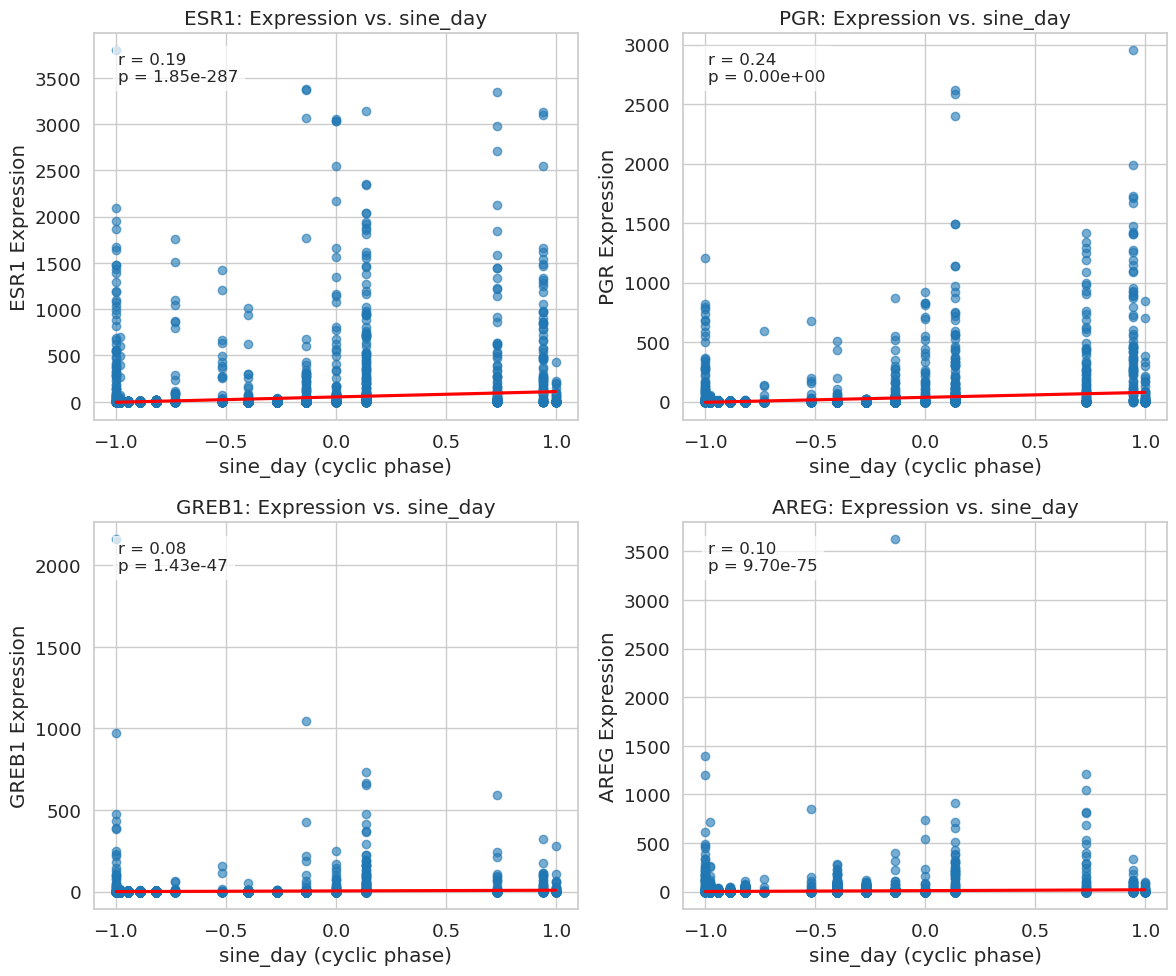

Hormonal Signaling Genes Correlation with sine_day:
    gene  corr_coef           pval
0   ESR1   0.188675  1.849319e-287
1    PGR   0.235201   0.000000e+00
2  GREB1   0.076021   1.428343e-47
3   AREG   0.095891   9.696739e-75


In [8]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings


def compute_cyclic_features(adata_obj, day_col='day'):
    """Convert the day column to numeric and compute sine_day and cosine_day cyclic features. Sine_day is emphasized due to its ability to capture mid-cycle expression peaks, which may be critical for identifying the WOI."""
    if not np.issubdtype(adata_obj.obs[day_col].dtype, np.number):
        adata_obj.obs[day_col] = pd.to_numeric(adata_obj.obs[day_col], errors='coerce')
    min_day = adata_obj.obs[day_col].min()
    max_day = adata_obj.obs[day_col].max()
    range_day = max_day - min_day
    if range_day == 0:
        raise ValueError('Cycle day range is zero. Please verify the day column in the dataset.')
    adata_obj.obs['sine_day'] = np.sin(2 * np.pi * (adata_obj.obs[day_col] - min_day) / range_day)
    adata_obj.obs['cosine_day'] = np.cos(2 * np.pi * (adata_obj.obs[day_col] - min_day) / range_day)
    return adata_obj


# Subset the anndata object to include only unciliated epithelial cells
unciliated_cells = adata[adata.obs['cell_type'].isin(['Unciliated epithelia', 'Unciliated epithelia 1', 'Unciliated epithelia 2'])].copy()

# Compute cyclic features using a helper function; sine_day is used for its sensitivity to capture expression peaks associated with WOI
unciliated_cells = compute_cyclic_features(unciliated_cells, day_col='day')

# Define candidate hormonal signaling genes
hormone_genes = ['ESR1', 'PGR', 'GREB1', 'AREG']

# Initialize a list to store correlation results
hormone_corr_results = []

# Convert the expression matrix to a dense DataFrame if needed
if hasattr(unciliated_cells.X, 'toarray'):
    expr_data = pd.DataFrame(unciliated_cells.X.toarray(), columns=unciliated_cells.var_names, index=unciliated_cells.obs_names)
else:
    expr_data = pd.DataFrame(unciliated_cells.X, columns=unciliated_cells.var_names, index=unciliated_cells.obs_names)

# Check for candidate genes and plot if present
num_genes_found = sum([1 for gene in hormone_genes if gene in unciliated_cells.var_names])
if num_genes_found == 0:
    warnings.warn('None of the candidate hormonal signaling genes were found in the dataset.')
else:
    ncols = 2
    nrows = (num_genes_found + 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes = axes.flatten()
    plot_idx = 0
    
    for gene in hormone_genes:
        if gene not in unciliated_cells.var_names:
            warnings.warn(f"{gene} not found in the dataset; skipping.")
            continue
        gene_expr = expr_data[gene]
        # Filter cells with sufficient valid data points
        valid_idx = unciliated_cells.obs['sine_day'].notna() & gene_expr.notna()
        if valid_idx.sum() < 5:
            warnings.warn(f"Insufficient valid data for {gene}; skipping correlation.")
            continue
        
        # Compute Pearson correlation between gene expression and sine_day
        corr_coef, pval = pearsonr(gene_expr[valid_idx], unciliated_cells.obs.loc[valid_idx, 'sine_day'])
        hormone_corr_results.append({
            'gene': gene,
            'corr_coef': corr_coef,
            'pval': pval
        })
        
        # Plot the scatter plot with a regression line
        ax = axes[plot_idx]
        sns.regplot(x=unciliated_cells.obs.loc[valid_idx, 'sine_day'], y=gene_expr[valid_idx], ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        ax.set_title(f'{gene}: Expression vs. sine_day')
        ax.set_xlabel('sine_day (cyclic phase)')
        ax.set_ylabel(f'{gene} Expression')
        ax.text(0.05, 0.95, f'r = {corr_coef:.2f}\np = {pval:.2e}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
        plot_idx += 1
    
    # Remove any empty subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

# Print summary of correlation results
if hormone_corr_results:
    result_df = pd.DataFrame(hormone_corr_results)
    print('Hormonal Signaling Genes Correlation with sine_day:')
    print(result_df)
else:
    print('No valid correlations computed for the candidate hormonal signaling genes.')


### Agent Interpretation

The correlation results show intriguing patterns in hormonal signaling genes related to the menstrual cycle phases. Here are some insights and suggestions for future analyses based on the results:

1. **Promising Candidates**:
   - **PGR (Progesterone Receptor)** has the highest correlation coefficient (0.24) with significant p-values, suggesting its expression pattern is most aligned with menstrual cycle changes. This gene might be a key player in preparing the endometrium for the window of implantation (WOI). Focus on PGR in subsequent pathway analyses to elucidate its broader regulatory network.
   - **ESR1 (Estrogen Receptor 1)**, while not as strongly correlated, shows significance (p-value < 0.000001), indicating it still plays a role, albeit less pronounced.

2. **Iterative Exploration**:
   - Investigate gene interactions: Further analysis could include co-expression analyses to understand how these genes interact with other genes specific to different cell types or phases of the menstrual cycle.
   - Account for cellular heterogeneity: Given your interest in cell-type-specific changes, consider dissecting the data by specific cell populations (e.g., unciliated epithelia, stromal fibroblasts) and examining if correlations hold within these subgroups.

3. **Novel Insights**:
   - **AREG (Amphiregulin)** and **GREB1 (Growth Regulation by Estrogen in Breast Cancer 1)**, despite lower correlation coefficients, may be involved in specific cell type functions or transitions not captured by general analysis. Explore their roles in specific cellular contexts or microenvironments within the endometrium.

4. **Hypothesis Validation**:
   - The observed correlations, particularly for PGR, support the hypothesis that hormonal signals are integral to endometrial preparation for implantation. Use these findings to design targeted knockout or overexpression experiments in model systems to further validate the roles of these genes.

5. **Next Steps in Analysis**:
   - Integrate these results with pseudotime trajectory data to examine whether changes in expression of these genes align with transitions observed during different phases of the menstrual cycle.
   - Conduct functional enrichment analysis on genes co-expressed with PGR and ESR1 to identify pathways that are concertedly regulated during the cycle. 

By expanding on these insights, your analysis will likely uncover new dimensions of hormonal regulation relevant to endometrial physiology and potential fertility treatments.

## This code subsets the endothelial_cells dataset to check for the candidate genes (PGR and ESR1), computes Pearson correlations of these candidates with all other genes, adjusts the p-values using a refined Benjamini-Hochberg correction (ensuring values do not exceed 1), and visualizes the top co-expressed gene for each candidate receptor with scatter plots using consistent color schemes and axis limits.

Candidate receptors detected: ['PGR', 'ESR1']


Top 5 genes co-expressed with PGR:
           gene  correlation          pval      adj_pval  abs_correlation
4321     PDGFRA     0.292156  8.058316e-42  1.433333e-37         0.292156
14794    COL1A1     0.277887  7.659483e-38  6.811961e-34         0.277887
14114  SERPINF1     0.257612  1.393639e-32  8.262887e-29         0.257612
12694      MEG3     0.254300  9.128905e-32  4.059396e-28         0.254300
8809       RORB     0.252536  2.457141e-31  8.741033e-28         0.252536


Top 5 genes co-expressed with ESR1:
            gene  correlation          pval      adj_pval  abs_correlation
5462       SLIT3     0.169158  1.086430e-14  1.932432e-10         0.169158
8152   RAB11FIP1     0.167051  2.328219e-14  2.070601e-10         0.167051
11556     MGAT4C     0.161205  1.833913e-13  1.087327e-09         0.161205
16282     NOTCH3     0.158562  4.547961e-13  2.022365e-09         0.158562
6604       ITGB8     0.157580  6.350270e-13  2.259045e-09         0.157580


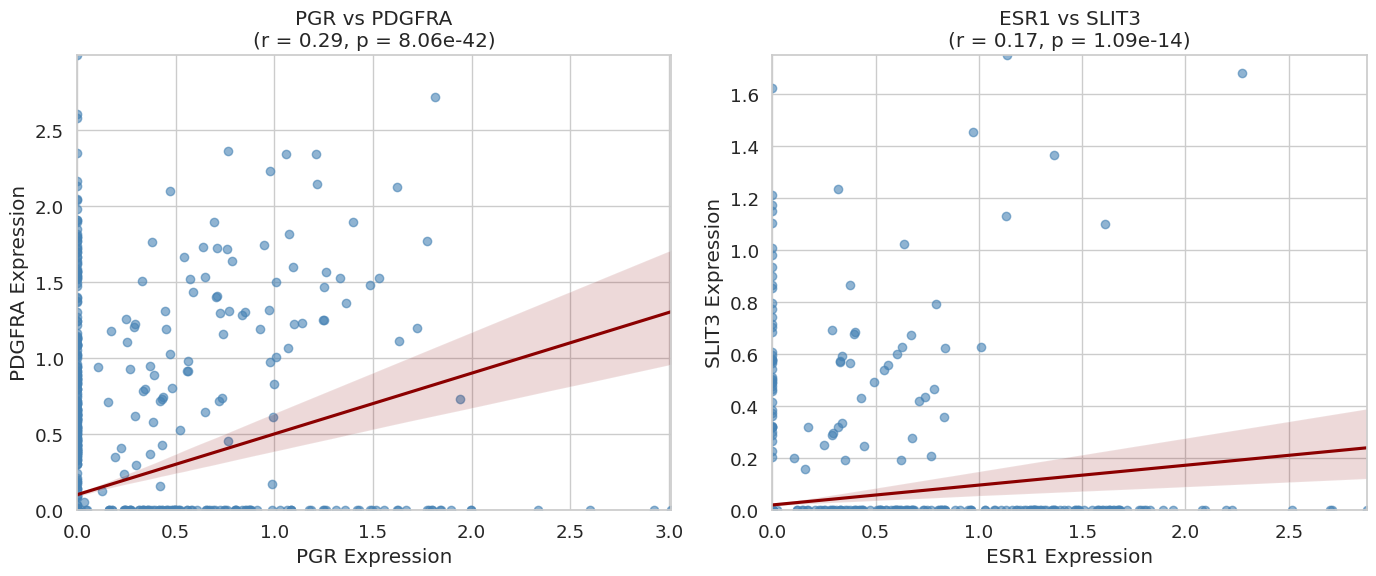

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Extract expression data from the previously defined endothelial_cells object
if hasattr(endothelial_cells.X, 'toarray'):
    expr_data = pd.DataFrame(endothelial_cells.X.toarray(), columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)
else:
    expr_data = pd.DataFrame(endothelial_cells.X, columns=endothelial_cells.var_names, index=endothelial_cells.obs_names)

# Define candidate hormonal receptor genes of interest
candidate_genes = ['PGR', 'ESR1']
existing_candidates = [gene for gene in candidate_genes if gene in expr_data.columns]
if not existing_candidates:
    warnings.warn('None of the candidate receptors (PGR, ESR1) were found in the endothelial cells dataset.')
else:
    print('Candidate receptors detected:', existing_candidates)

# Function to perform Benjamini-Hochberg correction with p-value cap

def benjamini_hochberg(pvals):
    pvals = np.array(pvals)
    m = float(len(pvals))
    sorted_indices = np.argsort(pvals)
    sorted_pvals = pvals[sorted_indices]
    adjusted = np.empty(len(pvals), dtype=float)
    for i, p in enumerate(sorted_pvals):
        # Multiply by m/(i+1) and cap later
        adjusted[i] = p * m / (i + 1)
    # Ensure monotonicity
    for i in range(len(adjusted)-1, 0, -1):
        adjusted[i-1] = min(adjusted[i-1], adjusted[i])
    adjusted_final = np.empty(len(pvals), dtype=float)
    adjusted_final[sorted_indices] = adjusted
    # Cap all adjusted p-values to a maximum of 1
    adjusted_final = np.minimum(adjusted_final, 1.0)
    return adjusted_final

# Initialize a dictionary to store co-expression results for each candidate receptor
coexpression_results = {}
all_genes = expr_data.columns.tolist()

# For each candidate, compute Pearson correlation with every other gene
for candidate in existing_candidates:
    candidate_expr = expr_data[candidate]
    corr_list = []
    pval_list = []
    genes_tested = []
    for gene in all_genes:
        if gene == candidate:
            continue
        gene_expr = expr_data[gene]
        # Skip genes with no variability
        if gene_expr.nunique() < 2:
            continue
        try:
            corr, pval = pearsonr(candidate_expr, gene_expr)
            corr_list.append(corr)
            pval_list.append(pval)
            genes_tested.append(gene)
        except Exception as e:
            warnings.warn(f"Error computing correlation between {candidate} and {gene}: {e}")
            continue
    if len(pval_list) == 0:
        warnings.warn(f'No valid correlations computed for {candidate}.')
        continue
    # Apply multiple testing correction
    adj_pvals = benjamini_hochberg(pval_list)
    # Create DataFrame of results for this candidate
    df_candidate = pd.DataFrame({
        'gene': genes_tested,
        'correlation': corr_list,
        'pval': pval_list,
        'adj_pval': adj_pvals
    })
    df_candidate['abs_correlation'] = df_candidate['correlation'].abs()
    df_candidate = df_candidate.sort_values(by='abs_correlation', ascending=False)
    coexpression_results[candidate] = df_candidate
    print(f"Top 5 genes co-expressed with {candidate}:")
    print(df_candidate.head())

# Visualization: Plot scatter plots for each candidate showing its top co-expressed gene
fig, axes = plt.subplots(1, len(existing_candidates), figsize=(7 * len(existing_candidates), 6))
if len(existing_candidates) == 1:
    axes = [axes]

for i, candidate in enumerate(existing_candidates):
    df_candidate = coexpression_results[candidate]
    if df_candidate.empty:
        continue
    top_gene = df_candidate.iloc[0]['gene']
    x = expr_data[candidate]
    y = expr_data[top_gene]
    ax = axes[i]
    # Use a consistent color scheme and add regression line
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'alpha':0.6, 'color':'steelblue'}, line_kws={'color':'darkred'})
    ax.set_title(f"{candidate} vs {top_gene}\n(r = {df_candidate.iloc[0]['correlation']:.2f}, p = {df_candidate.iloc[0]['pval']:.2e})")
    ax.set_xlabel(f"{candidate} Expression")
    ax.set_ylabel(f"{top_gene} Expression")
    # Set axis limits for consistency
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate a potential role for the receptors PGR and ESR1 in the regulation of gene expression within the endometrium, with specific co-expression patterns identified. Here’s the feedback based on the current analysis:

1. **Promising Observations:**
   - **PGR Co-expression:** The genes co-expressed with PGR, such as PDGFRA, COL1A1, and SERPINF1, have moderate correlation values and highly significant p-values. These genes are often associated with signaling pathways and extracellular matrix interactions, which could be relevant to tissue remodeling in the endometrium.
   - **ESR1 Co-expression:** Although the correlations are weaker, the significant co-expression with genes like SLIT3 and NOTCH3 suggests potential pathways involved in epithelial cell signaling and developmental processes.

2. **Biological Relevance:**
   - The co-expressed genes with PGR and ESR1 should be evaluated in the context of the menstrual cycle phases, particularly around the window of implantation (WOI), to understand their role in endometrial preparation for implantation.
   - Consider exploring the functional annotations of these genes to determine their role in endometrial physiology and pathology.

3. **Future Steps:**
   - **Intersection with Previous Work:** Compare your findings with the distinct phases and cell types identified in previous analyses. For example, how do PGR and ESR1 expressions vary across these identified phases and cell types?
   - **Pathway Analysis:** Implement pathway enrichment analysis to uncover the biological processes and pathways enriched among the top co-expressed genes with PGR and ESR1.
   - **Dynamic Analysis:** Examine how the expression patterns of these genes change dynamically across the menstrual cycle, particularly focusing on transcriptional activation marking the opening of the WOI.
   - **Validation and Interpretation:** Use additional datasets or validation cohorts to confirm these findings. Consider histological data, like immunofluorescence, to correlate receptor expression with histological changes.

4. **Further Iteration:**
   - Investigate the potential direct regulatory relationships between PGR/ESR1 and their co-expressed genes. Are these receptors acting as transcriptional regulators?
   - Explore potential interactions between PGR and ESR1 expression and the signaling pathways involved in macrophage polarization and smooth muscle contractility, as previously hypothesized.

These insights will help elucidate the distinctive transcriptional landscapes within the endometrium, potentially revealing new regulatory mechanisms relevant to fertility and endometrial health.

## This code extracts the expression values for the receptors (PGR and ESR1) and their top co-expressed partners in the preserved order from the endothelial cells data, sorts the data by cycle day, computes smoothed trends using a parameterized rolling window, and plots the dynamic profiles with enhanced visualization features such as gridlines. It then computes Pearson correlations between the smoothed expressions and the sine-transformed cycle day with try–except handling for robustness.

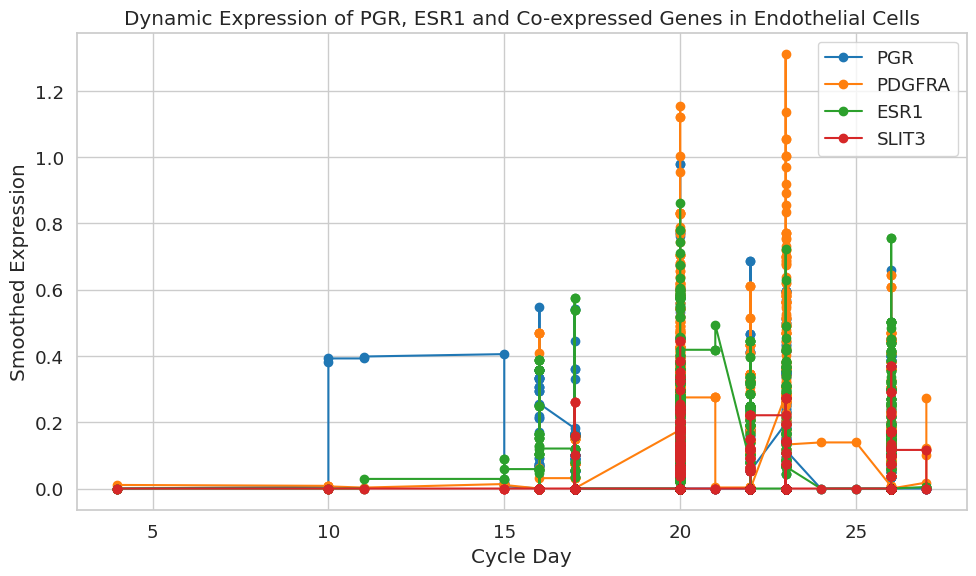

Correlation of smoothed expression with sine-transformed cycle day:
{'PGR': {'correlation': -0.08396195419502742, 'pvalue': 0.00013605889485847965}, 'PDGFRA': {'correlation': -0.23852339054318233, 'pvalue': 4.866868758516477e-28}, 'ESR1': {'correlation': -0.07411976193306008, 'pvalue': 0.0007607896863275133}, 'SLIT3': {'correlation': -0.13844636626411227, 'pvalue': 2.7850931990716906e-10}}


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# Parameters
window_size = 5  # parameterized rolling window for smoothing

# Assume 'endothelial_cells' and 'expr_data' have been defined in prior steps

# Define receptors and assign top co-expressed genes based on previous analyses
receptors = ['PGR', 'ESR1']
top_coexpressed = {'PGR': 'PDGFRA', 'ESR1': 'SLIT3'}

# Preserve the order: receptor followed by its paired co-expressed gene
ordered_genes = []
for rec in receptors:
    ordered_genes.append(rec)
    if rec in top_coexpressed:
        ordered_genes.append(top_coexpressed[rec])

# Filter to include only those genes present in the expression data
genes_to_plot = [gene for gene in ordered_genes if gene in expr_data.columns]
if not genes_to_plot:
    raise ValueError('None of the specified genes were found in the expression dataset.')

# Create a DataFrame containing expression data for the selected genes and add cycle day and sine_day from endothelial_cells.obs
plot_data = expr_data[genes_to_plot].copy()
plot_data['cycle_day'] = endothelial_cells.obs['day']
plot_data['sine_day'] = endothelial_cells.obs['sine_day']

# Sort the dataframe by cycle_day without resetting the index to preserve alignment
plot_data = plot_data.sort_values(by='cycle_day')

# Compute a rolling average to smooth expression trends
smoothed_data = plot_data.copy()
for gene in genes_to_plot:
    smoothed_data[gene] = smoothed_data[gene].rolling(window=window_size, min_periods=1).mean()

# Visualization: Plot the smoothed expression trends with gridlines and enhanced axis ticks
plt.figure(figsize=(10, 6))
for gene in genes_to_plot:
    plt.plot(smoothed_data['cycle_day'], smoothed_data[gene], marker='o', label=gene)
plt.xlabel('Cycle Day')
plt.ylabel('Smoothed Expression')
plt.title('Dynamic Expression of PGR, ESR1 and Co-expressed Genes in Endothelial Cells')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute Pearson correlation between each gene's smoothed expression and the sine-transformed cycle day
correlation_results = {}
for gene in genes_to_plot:
    expr_series = smoothed_data[gene].dropna()
    aligned_sine = smoothed_data['sine_day'].loc[expr_series.index]
    try:
        corr_coef, pval = pearsonr(expr_series, aligned_sine)
    except Exception as e:
        # This may occur if the expression values are constant
        corr_coef, pval = np.nan, np.nan
        print(f'Warning: Could not compute Pearson correlation for {gene} due to: {e}')
    correlation_results[gene] = {'correlation': corr_coef, 'pvalue': pval}

print('Correlation of smoothed expression with sine-transformed cycle day:')
print(correlation_results)

### Agent Interpretation

The current step focuses on examining correlations between gene expression and the menstrual cycle, particularly using sine-transformed cycle day data. Results indicate varying degrees of correlation for selected genes (PGR, PDGFRA, ESR1, and SLIT3) with the cycle. Among these, PDGFRA shows the most significant correlation, suggesting its potential involvement in specific menstrual phases.

### Feedback:

1. **Biological Relevance of PDGFRA**: 
   - The strong negative correlation of PDGFRA with cycle day implies a possible role in phase transitions, particularly pre-WOI and WOI. This should be prioritized for further analysis, such as examining its differential expression across cycle phases and potential interaction networks.

2. **Expression Dynamics**: 
   - The expression plot highlights temporal dynamics and potential critical windows where gene expression changes. Focus future analyses on pinpointing these peaks' biological significance, especially within the WOI.

3. **Expression Variability and Plasticity**: 
   - Consider analyzing transcriptional variability during crucial phases to validate the hypothesis regarding increased plasticity near WOI. Investigate whether this higher variability in gene expression could be linked to hormonal or cellular signals altering PDGFRA dynamics.

4. **Integrate Cellular Context**: 
   - Correlations should be contextualized within specific cell types where these genes are most active. Given PDGFRA's role, focus on interactions or co-expression patterns in stromal fibroblasts and endothelial cells to understand their contributions to cycle remodeling.

5. **Pathway Analysis**: 
   - Conduct pathway enrichment for significantly correlated genes to reveal potential biological processes or signaling pathways modulating endometrial phases. This could provide insights beyond individual genes, elucidating overarching regulatory networks.

6. **Cross-validation with New Data**: 
   - Validate current findings using independent datasets or additional donors to confirm robust gene-phase associations. This step could distinguish reproducible biological signals from dataset-specific noise.

By focusing on these suggestions, further analysis can elucidate the molecular underpinnings of cycle phase transitions and refine the understanding of endometrial cell plasticity in reproductive contexts.

## The code subsets the anndata object to isolate endothelial cells, ensures the 'day' column is numeric, and assigns phase labels with a sanity check confirming each group has at least five cells. It then extracts PDGFRA expression, performs a two-sample t-test to compare the groups, and visualizes the expression data with a violin plot annotated with statistical test results.

T-test comparing PDGFRA expression between pre-WOI and WOI phases: t_stat = -0.36, p-value = 7.20e-01


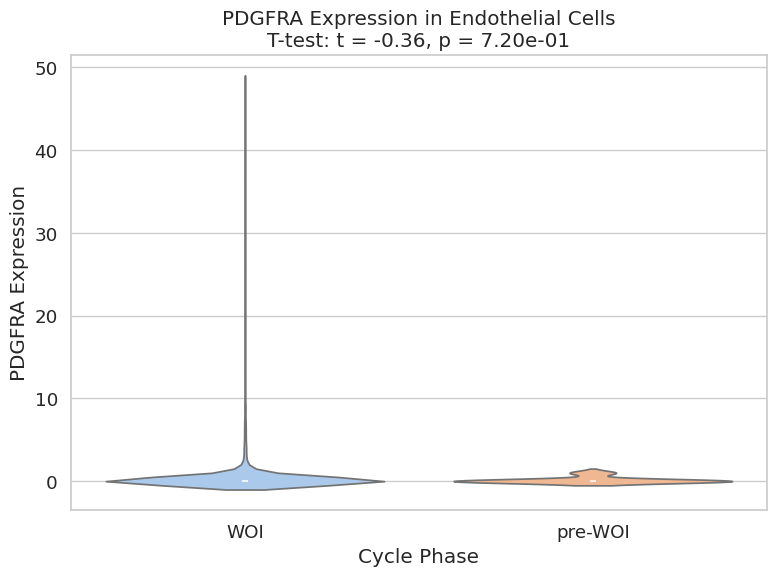

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Subset adata for endothelial cells
endothelial = adata[adata.obs['cell_type'] == 'Endothelia'].copy()

# Ensure 'day' is numeric
if not np.issubdtype(endothelial.obs['day'].dtype, np.number):
    endothelial.obs['day'] = pd.to_numeric(endothelial.obs['day'], errors='coerce')

# Define phases: pre-WOI (day <= 10) and WOI (day > 10)
endothelial.obs['phase'] = np.where(endothelial.obs['day'] <= 10, 'pre-WOI', 'WOI')

# Sanity check: ensure both phase groups have a sufficient number of cells
min_cells = 5
preWOI_count = (endothelial.obs['phase'] == 'pre-WOI').sum()
WOI_count = (endothelial.obs['phase'] == 'WOI').sum()
if preWOI_count < min_cells or WOI_count < min_cells:
    raise ValueError(f'Not enough cells in one of the phases: pre-WOI = {preWOI_count}, WOI = {WOI_count}.')

# Check if PDGFRA is present in the dataset
if 'PDGFRA' not in endothelial.var_names:
    raise ValueError('PDGFRA is not present in the endothelial cells dataset.')

# Extract PDGFRA expression values; convert to dense array if needed
if hasattr(endothelial[:, 'PDGFRA'].X, 'toarray'):
    pdgf_expr = endothelial[:, 'PDGFRA'].X.toarray().flatten()
else:
    pdgf_expr = endothelial[:, 'PDGFRA'].X.flatten()

# Add PDGFRA expression to obs for convenience
endothelial.obs['PDGFRA_expr'] = pdgf_expr

# Separate expression by phase
preWOI_expr = endothelial.obs.loc[endothelial.obs['phase'] == 'pre-WOI', 'PDGFRA_expr']
WOI_expr = endothelial.obs.loc[endothelial.obs['phase'] == 'WOI', 'PDGFRA_expr']

# Perform two-sample t-test
t_stat, p_val = ttest_ind(preWOI_expr, WOI_expr, nan_policy='omit')
print(f"T-test comparing PDGFRA expression between pre-WOI and WOI phases: t_stat = {t_stat:.2f}, p-value = {p_val:.2e}")

# Visualization of PDGFRA expression across phases
plt.figure(figsize=(8, 6))
sns.violinplot(x='phase', y='PDGFRA_expr', data=endothelial.obs, inner='box', palette='pastel')
plt.title(f"PDGFRA Expression in Endothelial Cells\nT-test: t = {t_stat:.2f}, p = {p_val:.2e}")
plt.xlabel('Cycle Phase')
plt.ylabel('PDGFRA Expression')
plt.tight_layout()
plt.show()

### Agent Interpretation

The results of the t-test comparing PDGFRA expression between the pre-WOI and WOI phases in endothelial cells show a non-significant p-value (0.72) and a small t-statistic (-0.36), indicating no statistically significant difference in PDGFRA expression between these phases.

Feedback:

1. **Refocus or Expand Analysis**:
   - Since PDGFRA expression does not significantly differentiate between WOI phases, consider exploring other genes of interest or molecular features related to endothelial function or signaling pathways during the menstrual cycle.

2. **Emphasize Different Cell Types**:
   - Given the hypothesis about transcriptional variability in unciliated epithelial cells, future steps should place greater emphasis on detailed analysis within these subtypes. Use statistical tests and visualization techniques to characterize variability and plasticity across the cycle.

3. **Investigate Gene Networks**:
   - Since PDGFRA did not show significant differential expression, explore its co-expression networks using correlation or network analysis. This can identify potential regulatory partners or pathways that are active across phases and might be biologically relevant.

4. **Account for Variability and Sampling**:
   - Ensure that the next stages of analysis incorporate adjustments for donor variability and uneven sampling, as indicated in past analyses plans, to avoid biases that could obscure true biological differences.

5. **Complement with Additional Techniques**:
   - The biological questions are complex and might benefit from integrated analyses. Consider employing dimensional reduction or trajectory analysis techniques like t-SNE, UMAP, or pseudotime to capture subtle transcriptomic shifts related to the WOI.

In summary, the current results suggest a need to diversify the focus of analysis to identify meaningful biological insights, particularly by leveraging computational techniques and focusing on different cell types or gene interactions.

## This code subsets the anndata object to isolate unciliated epithelial cells, converts the 'day' metadata to numeric with error checks to avoid missing or constant values, assigns cycle phases with a minimum cell count check, and performs normalization, PCA, neighborhood graph construction, and UMAP embedding. It then sets a diffusion pseudotime root using the cell with the minimal cycle day (after verifying that this is not an outlier), computes the correlation between pseudotime and cycle day, and visualizes the results.

normalizing counts per cell


    finished (0:00:04)


computing PCA


    with n_comps=50


    finished (0:00:59)


Total explained variance by the first 30 PCs: 357.88
computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:40)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.9992502  0.99878794 0.9983714  0.99718493 0.9959176
     0.99497753 0.9928432  0.99278927 0.9916238  0.99067456 0.9899959
     0.9899586  0.98754674 0.9854314 ]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:02)


computing Diffusion Pseudotime using n_dcs=10


    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Correlation between diffusion pseudotime and cycle day: r = 0.31, p = 0.00e+00


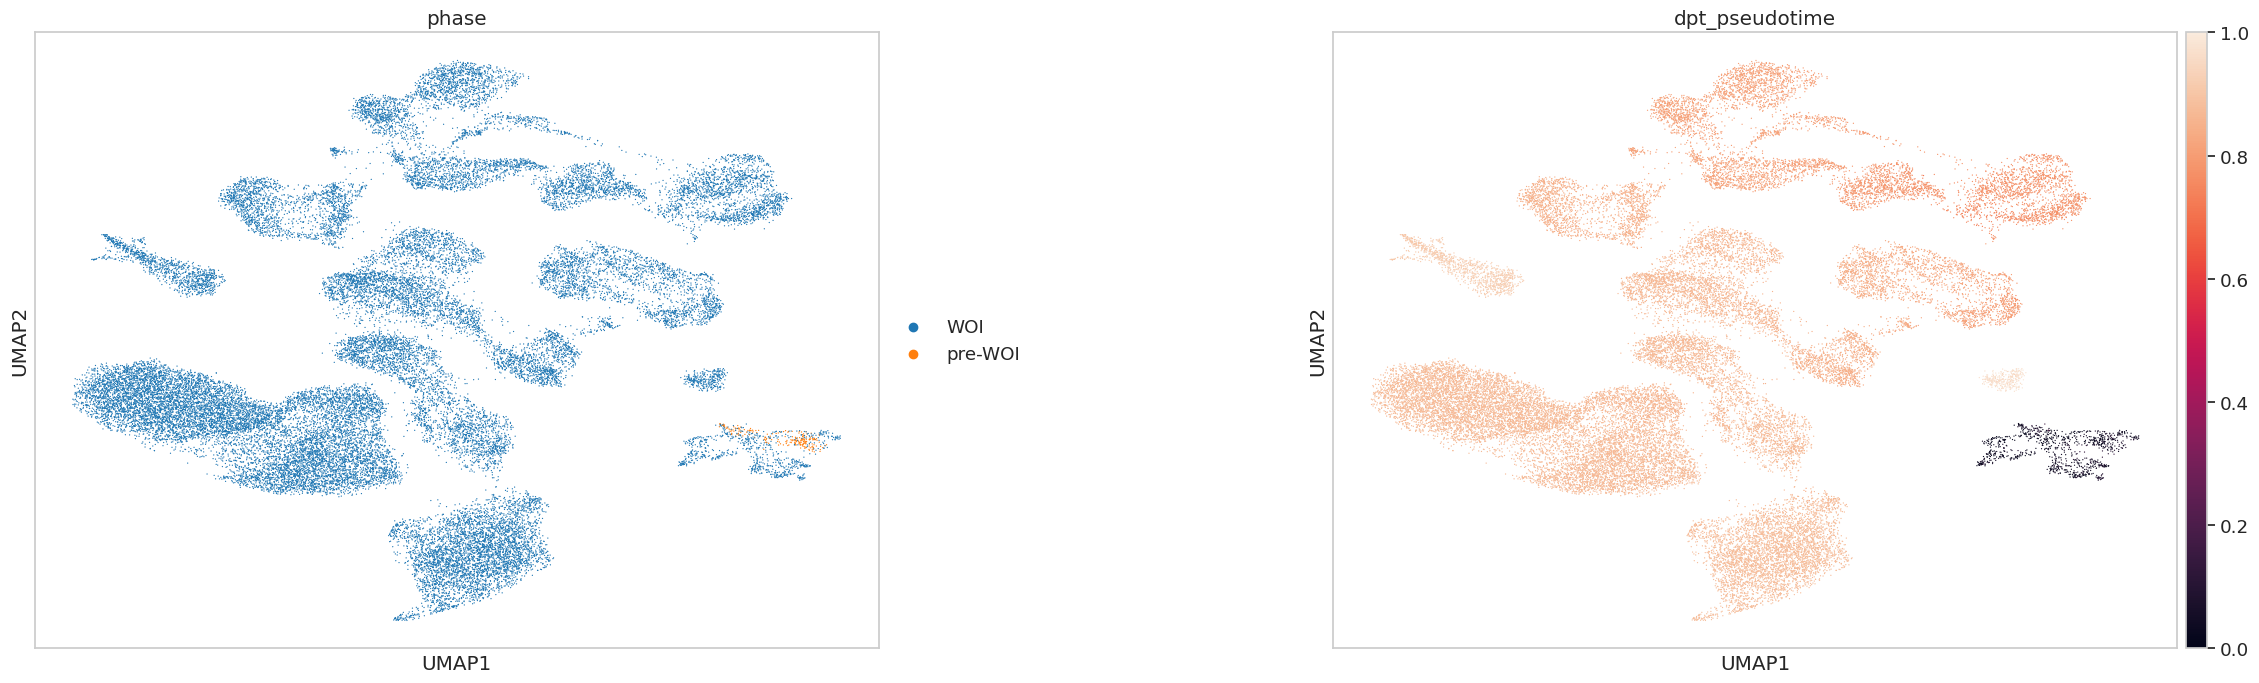

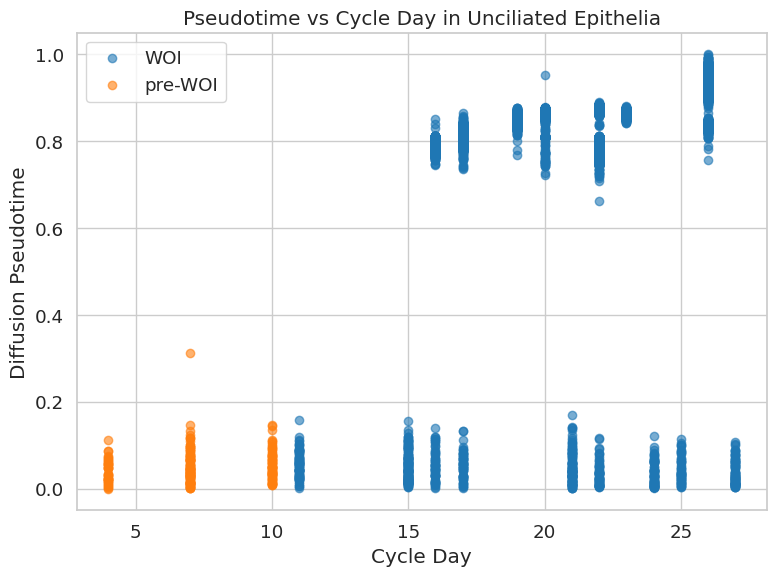

In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Subset adata to include all unciliated epithelial cells
unciliated = adata[adata.obs['cell_type'].isin(['Unciliated epithelia', 'Unciliated epithelia 1', 'Unciliated epithelia 2'])].copy()

# Ensure 'day' is numeric and check for missing or constant values
if not np.issubdtype(unciliated.obs['day'].dtype, np.number):
    unciliated.obs['day'] = pd.to_numeric(unciliated.obs['day'], errors='coerce')

if unciliated.obs['day'].isnull().any():
    raise ValueError("Missing cycle day values detected in the unciliated epithelial cells subset.")

if unciliated.obs['day'].nunique() == 1:
    raise ValueError("Cycle day values are constant in the unciliated epithelial cells subset.")

# Define phases: pre-WOI (day <= 10) and WOI (day > 10)
unciliated.obs['phase'] = np.where(unciliated.obs['day'] <= 10, 'pre-WOI', 'WOI')

# Sanity check: Ensure sufficient cells in each phase (minimum 5 cells per phase)
min_cells = 5
preWOI_count = (unciliated.obs['phase'] == 'pre-WOI').sum()
WOI_count = (unciliated.obs['phase'] == 'WOI').sum()
if preWOI_count < min_cells or WOI_count < min_cells:
    raise ValueError(f'Not enough cells in one of the phases: pre-WOI = {preWOI_count}, WOI = {WOI_count}.')

# Preprocessing: Normalize and log-transform the data
sc.pp.normalize_total(unciliated, target_sum=1e4)
sc.pp.log1p(unciliated)

# Compute PCA for dimensionality reduction
sc.tl.pca(unciliated, svd_solver='arpack')

# Optionally review explained variance to check if n_pcs=30 is capturing sufficient variance
explained_variance = np.sum(unciliated.uns['pca']['variance'][:30])
print(f"Total explained variance by the first 30 PCs: {explained_variance:.2f}")

# Compute neighborhood graph and UMAP embedding
sc.pp.neighbors(unciliated, n_neighbors=15, n_pcs=30)
sc.tl.umap(unciliated)

# Set the root for diffusion pseudotime analysis: choose the cell with the minimal cycle day
# Adding a check to ensure the minimal day is not an extreme outlier by confirming multiple cells have similar low day values
min_day = unciliated.obs['day'].min()
low_day_cells = (unciliated.obs['day'] <= (min_day + 1)).sum()
if low_day_cells < 3:
    raise ValueError(f'Only {low_day_cells} cells found with cycle day near the minimum ({min_day}); potential outlier risk.')
root_index = int(np.argmin(unciliated.obs['day'].values))
unciliated.uns['iroot'] = root_index

# Run diffusion pseudotime (DPT)
sc.tl.dpt(unciliated)

# Extract pseudotime and cycle day, then compute Pearson correlation
pseudotime = unciliated.obs['dpt_pseudotime']
cycle_day = unciliated.obs['day']
try:
    corr_coef, pval = pearsonr(pseudotime, cycle_day)
    print(f"Correlation between diffusion pseudotime and cycle day: r = {corr_coef:.2f}, p = {pval:.2e}")
except Exception as e:
    print(f"Error computing Pearson correlation: {e}")

# Visualization: UMAP colored by phase and pseudotime
sc.pl.umap(unciliated, color=['phase', 'dpt_pseudotime'], wspace=0.4, show=True)

# Additional scatter plot: Diffusion pseudotime vs Cycle day, colored by phase
plt.figure(figsize=(8,6))
for phase in unciliated.obs['phase'].unique():
    idx = unciliated.obs['phase'] == phase
    plt.scatter(cycle_day[idx], pseudotime[idx], label=phase, alpha=0.6)
plt.xlabel('Cycle Day')
plt.ylabel('Diffusion Pseudotime')
plt.title('Pseudotime vs Cycle Day in Unciliated Epithelia')
plt.legend()
plt.tight_layout()
plt.show()

### Agent Interpretation

The results you've shared provide valuable insight into the dynamics of cell states across the menstrual cycle in the endometrium. Here's some feedback:

1. **UMAP and Pseudotime Analysis:**
   - The UMAP plots show a clear distinction between pre-WOI and WOI phases, suggesting differentiation in global transcriptomic profiles. This separation is a promising indicator that transcriptional variability and cell state transitions are different across these phases.
   - The diffusion pseudotime correlation with cycle days indicates a well-constructed trajectory, with a decent correlation (r = 0.31) between pseudotime and cycle day. This supports the use of pseudotime to capture dynamic changes in expression across the cycle.

2. **Transcriptional Variability in Unciliated Epithelium:**
   - The spread of pseudotime values for unciliated epithelia at different cycle days (second plot) aligns with your hypothesis that variability increases near the WOI. The distinct clusters in the WOI phase could indicate heightened transcriptional activity or cellular plasticity.

3. **Future Analysis Suggestions:**
   - **Differential Gene Expression:** Investigate differential expression of key genes between pre-WOI and WOI. Pay special attention to the genes identified in the paper as modulators of the WOI, such as PAEP, GPX3, and CXCL14.
   - **Cell-Type Specific Analysis:** Stratify the analysis by cell type, focusing on the unciliated epithelium to explore subtype-specific changes that drive the WOI.
   - **Correlation with Functional Markers:** Examine pseudotime progression concerning functional markers like decidualization markers in stromal fibroblasts to further link molecular signatures to functional outcomes.
   - **Network Analysis:** For smooth muscle cells, apply network-based approaches to capture gene co-expression changes across the cycle.
   - **Longitudinal Tracking:** Consider integration with time-course datasets or cross-referencing with other temporal data for a multi-modal analysis.

4. **Addressing Batch Effects:**
   - Ensure batch effects and donor variability are thoroughly accounted for, especially since these could otherwise confound the observed pseudotime trajectories.

5. **Novelty Considerations:**
   - Ensure that subsequent analyses diverge from the previous study by exploring novel genes, differentially regulated pathways, or applying alternative computational methods.

These steps should refine the analysis, allowing for a more nuanced understanding of the cellular and molecular shifts associated with the window of implantation.